In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# --- Black-Scholes formula for a European put ---
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# --- Parameters ---
initial_wealth = 10000
mu = 0.1266
T = 1
r = 0.022752
n_steps = 252
dt = T / n_steps
n_paths = 10000
K = 10000
weight = 0.10
halfway = n_steps // 2

# --- Define scenarios ---
scenarios = {
    "Baseline": {"sigma": 0.1986, "drop": False},
    "Stress Low Vol (−5pp)": {"sigma": 0.1486, "drop": True},
    "Stress High Vol (+5pp)": {"sigma": 0.2486, "drop": True}
}

# --- Simulate shared random numbers for comparability ---
np.random.seed(42)
Z = np.random.standard_normal((n_paths, n_steps))

discounted_values_dict = {}
# --- Loop through scenarios ---
for label, params in scenarios.items():
    sigma = params["sigma"]
    drop = params["drop"]

    # --- Simulate index paths ---
    paths = np.zeros_like(Z)
    paths[:, 0] = initial_wealth

    for t in range(1, n_steps):
        paths[:, t] = paths[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    if drop:
        paths[:, halfway:] *= 0.8  # apply 20% drop from T = 0.5 onward

    final_index_values = paths[:, -1]

    # --- Hedged portfolio ---
    put_price = black_scholes_put(initial_wealth, K, T, r, sigma)
    budget_puts = initial_wealth * weight
    n_puts = budget_puts / put_price
    remaining_equity = initial_wealth - budget_puts
    put_payoffs = np.maximum(K - final_index_values, 0)
    final_values = remaining_equity * (final_index_values / initial_wealth) + n_puts * put_payoffs

    # --- Discount and compute returns ---
    discounted_values = final_values * np.exp(-r * T)
    returns = discounted_values / initial_wealth - 1

    discounted_values_dict[label] = discounted_values.copy()
    # --- Print results ---
    print(f"\n--- {label} ---")
    print(f"Volatility: {sigma:.4f}, Put Price: {put_price:.2f} €, Drop Applied: {drop}")
    print(f"Mean return: {np.mean(returns):.4f}")
    print(f"Standard deviation: {np.std(returns):.4f}")
    print(f"VaR (95%): {np.percentile(returns, 5):.4f}")
    print(f"ES (95%): {returns[returns <= np.percentile(returns, 5)].mean():.4f}")
    print(f"VaR (99%): {np.percentile(returns, 1):.4f}")
    print(f"ES (99%): {returns[returns <= np.percentile(returns, 1)].mean():.4f}")
    print(f"Sharpe Ratio: {np.mean(returns) / np.std(returns):.4f}")


--- Baseline ---
Volatility: 0.1986, Put Price: 674.74 €, Drop Applied: False
Mean return: 0.0444
Standard deviation: 0.1503
VaR (95%): -0.1106
ES (95%): -0.1154
VaR (99%): -0.1184
ES (99%): -0.1193
Sharpe Ratio: 0.2952

--- Stress Low Vol (−5pp) ---
Volatility: 0.1486, Put Price: 479.98 €, Drop Applied: True
Mean return: 0.0305
Standard deviation: 0.1050
VaR (95%): -0.1082
ES (95%): -0.1143
VaR (99%): -0.1178
ES (99%): -0.1191
Sharpe Ratio: 0.2901

--- Stress High Vol (+5pp) ---
Volatility: 0.2486, Put Price: 869.69 €, Drop Applied: True
Mean return: -0.0379
Standard deviation: 0.0952
VaR (95%): -0.1143
ES (95%): -0.1173
VaR (99%): -0.1191
ES (99%): -0.1197
Sharpe Ratio: -0.3982


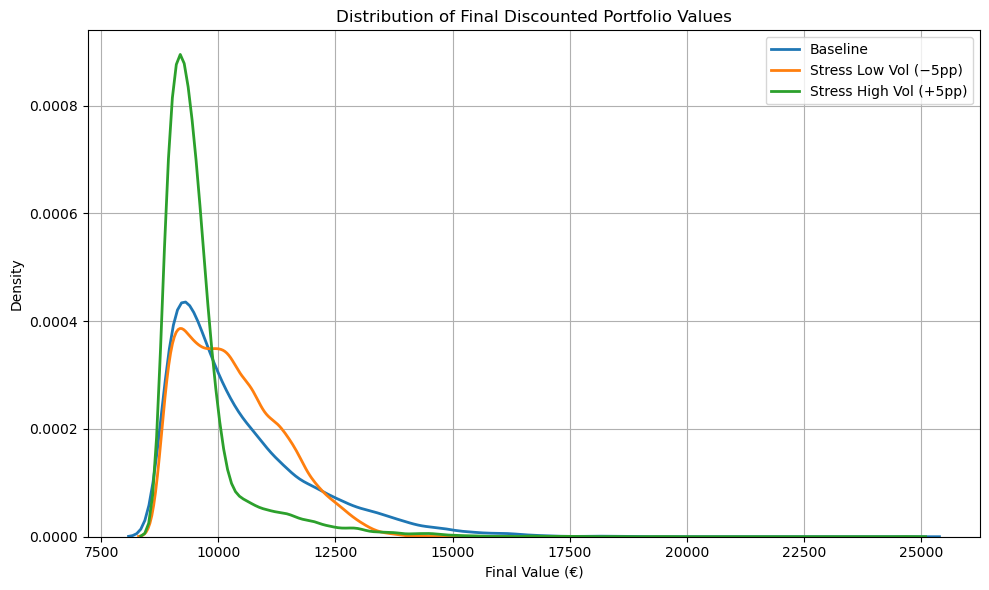

In [2]:
###=========Plot the distributions of all Scenarios===============

# Extract arrays from dictionary
discounted_values_baseline = discounted_values_dict["Baseline"]
discounted_values_low_vol = discounted_values_dict["Stress Low Vol (−5pp)"]
discounted_values_high_vol = discounted_values_dict["Stress High Vol (+5pp)"]

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.kdeplot(discounted_values_baseline, label='Baseline', linewidth=2)
sns.kdeplot(discounted_values_low_vol, label='Stress Low Vol (−5pp)', linewidth=2)
sns.kdeplot(discounted_values_high_vol, label='Stress High Vol (+5pp)', linewidth=2)

plt.title('Distribution of Final Discounted Portfolio Values')
plt.xlabel('Final Value (€)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("stress_distribution.pdf", format='pdf', dpi=300)
plt.show()

In [3]:
### Code without baseline unhedged

In [4]:
import numpy as np
from scipy.stats import norm

# --- Black-Scholes formula for a European put ---
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# --- Fixed parameters ---
initial_wealth = 10000
mu = 0.1266
T = 1
r = 0.022752
n_steps = 252
dt = T / n_steps
n_paths = 10000
K = 10000
weight = 0.10
halfway = n_steps // 2

# --- Define extended scenarios ---
scenarios = {
    "Baseline": {"sigma": 0.1986, "drop": False},
    "Only Drop (−20%)": {"sigma": 0.1986, "drop": True},
    "Only Low Vol (−5pp)": {"sigma": 0.1486, "drop": False},
    "Only High Vol (+5pp)": {"sigma": 0.2486, "drop": False},
    "Drop + Low Vol": {"sigma": 0.1486, "drop": True},
    "Drop + High Vol": {"sigma": 0.2486, "drop": True}
}

# --- Simulate shared random numbers ---
np.random.seed(42)
Z = np.random.standard_normal((n_paths, n_steps))

discounted_values_dict = {}
returns_dict = {}

for label, params in scenarios.items():
    sigma = params["sigma"]
    drop = params["drop"]

    paths = np.zeros_like(Z)
    paths[:, 0] = initial_wealth

    for t in range(1, n_steps):
        paths[:, t] = paths[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    if drop:
        paths[:, halfway:] *= 0.8

    final_index_values = paths[:, -1]

    put_price = black_scholes_put(initial_wealth, K, T, r, sigma)
    budget_puts = initial_wealth * weight
    n_puts = budget_puts / put_price
    remaining_equity = initial_wealth - budget_puts
    put_payoffs = np.maximum(K - final_index_values, 0)
    final_values = remaining_equity * (final_index_values / initial_wealth) + n_puts * put_payoffs

    discounted_values = final_values * np.exp(-r * T)
    returns = discounted_values / initial_wealth - 1

    discounted_values_dict[label] = discounted_values.copy()
    returns_dict[label] = returns.copy()

    print(f"\n--- {label} ---")
    print(f"Volatility: {sigma:.4f}, Put Price: {put_price:.2f} €, Drop Applied: {drop}")
    print(f"Mean return: {np.mean(returns):.4f}")
    print(f"Standard deviation: {np.std(returns):.4f}")
    print(f"VaR (95%): {np.percentile(returns, 5):.4f}")
    print(f"ES (95%): {returns[returns <= np.percentile(returns, 5)].mean():.4f}")
    print(f"VaR (99%): {np.percentile(returns, 1):.4f}")
    print(f"ES (99%): {returns[returns <= np.percentile(returns, 1)].mean():.4f}")
    print(f"Sharpe Ratio: {np.mean(returns) / np.std(returns):.4f}")


--- Baseline ---
Volatility: 0.1986, Put Price: 674.74 €, Drop Applied: False
Mean return: 0.0444
Standard deviation: 0.1503
VaR (95%): -0.1106
ES (95%): -0.1154
VaR (99%): -0.1184
ES (99%): -0.1193
Sharpe Ratio: 0.2952

--- Only Drop (−20%) ---
Volatility: 0.1986, Put Price: 674.74 €, Drop Applied: True
Mean return: -0.0142
Standard deviation: 0.0772
VaR (95%): -0.1104
ES (95%): -0.1152
VaR (99%): -0.1181
ES (99%): -0.1191
Sharpe Ratio: -0.1836

--- Only Low Vol (−5pp) ---
Volatility: 0.1486, Put Price: 479.98 €, Drop Applied: False
Mean return: 0.0321
Standard deviation: 0.1155
VaR (95%): -0.1066
ES (95%): -0.1138
VaR (99%): -0.1178
ES (99%): -0.1190
Sharpe Ratio: 0.2776

--- Only High Vol (+5pp) ---
Volatility: 0.2486, Put Price: 869.69 €, Drop Applied: False
Mean return: 0.0528
Standard deviation: 0.1915
VaR (95%): -0.1140
ES (95%): -0.1171
VaR (99%): -0.1191
ES (99%): -0.1196
Sharpe Ratio: 0.2756

--- Drop + Low Vol ---
Volatility: 0.1486, Put Price: 479.98 €, Drop Applied: True


In [5]:
### Code with baseline unhedged (includes the baseline 
# value distirbution from last task)

In [6]:
import numpy as np
from scipy.stats import norm

# --- Black-Scholes formula for a European put ---
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# --- Fixed parameters ---
initial_wealth = 10000
mu = 0.1266
T = 1
r = 0.022752
n_steps = 252
dt = T / n_steps
n_paths = 10000
K = 10000
weight = 0.10
halfway = n_steps // 2

# --- Simulate shared random numbers for comparability ---
np.random.seed(42)
Z = np.random.standard_normal((n_paths, n_steps))

discounted_values_dict = {}

# --- Add Unhedged Baseline --- #unhedged distribution from last task
paths = np.zeros_like(Z)
paths[:, 0] = initial_wealth
for t in range(1, n_steps):
    paths[:, t] = paths[:, t - 1] * np.exp((mu - 0.5 * 0.1986**2) * dt + 0.1986 * np.sqrt(dt) * Z[:, t - 1])
final_values = paths[:, -1]
discounted_values = final_values * np.exp(-r * T)
discounted_values_dict["Unhedged"] = discounted_values.copy()

# --- Define hedged scenarios ---
scenarios = {
    "Baseline Hedged": {"sigma": 0.1986, "drop": False},
    "Only Drop (−20%)": {"sigma": 0.1986, "drop": True},
    "Only Low Vol (−5pp)": {"sigma": 0.1486, "drop": False},
    "Only High Vol (+5pp)": {"sigma": 0.2486, "drop": False},
    "Drop + Low Vol": {"sigma": 0.1486, "drop": True},
    "Drop + High Vol": {"sigma": 0.2486, "drop": True}
}

# --- Loop through scenarios ---
for label, params in scenarios.items():
    sigma = params["sigma"]
    drop = params["drop"]

    paths = np.zeros_like(Z)
    paths[:, 0] = initial_wealth
    for t in range(1, n_steps):
        paths[:, t] = paths[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    if drop:
        paths[:, halfway:] *= 0.8

    final_index_values = paths[:, -1]

    put_price = black_scholes_put(initial_wealth, K, T, r, sigma)
    budget_puts = initial_wealth * weight
    n_puts = budget_puts / put_price
    remaining_equity = initial_wealth - budget_puts
    put_payoffs = np.maximum(K - final_index_values, 0)
    final_values = remaining_equity * (final_index_values / initial_wealth) + n_puts * put_payoffs

    discounted_values = final_values * np.exp(-r * T)
    discounted_values_dict[label] = discounted_values.copy()



# --- Compute and print performance and risk metrics for all hedged scenarios ---
for label in discounted_values_dict:
    if label == "Unhedged":
        continue  # skip unhedged if already printed separately

    returns = discounted_values_dict[label] / initial_wealth - 1
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    value_at_risk_95 = np.percentile(returns, 5)
    value_at_risk_99 = np.percentile(returns, 1)
    expected_shortfall_95 = returns[returns <= value_at_risk_95].mean()
    expected_shortfall_99 = returns[returns <= value_at_risk_99].mean()
    sharpe_ratio = mean_return / std_dev

    print(f"\n--- {label} ---")
    print(f"Mean return: {mean_return:.4f}")
    print(f"Standard deviation: {std_dev:.4f}")
    print(f"VaR (95%): {value_at_risk_95:.4f}")
    print(f"ES (95%): {expected_shortfall_95:.4f}")
    print(f"VaR (99%): {value_at_risk_99:.4f}")
    print(f"ES (99%): {expected_shortfall_99:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


--- Baseline Hedged ---
Mean return: 0.0444
Standard deviation: 0.1503
VaR (95%): -0.1106
ES (95%): -0.1154
VaR (99%): -0.1184
ES (99%): -0.1193
Sharpe Ratio: 0.2952

--- Only Drop (−20%) ---
Mean return: -0.0142
Standard deviation: 0.0772
VaR (95%): -0.1104
ES (95%): -0.1152
VaR (99%): -0.1181
ES (99%): -0.1191
Sharpe Ratio: -0.1836

--- Only Low Vol (−5pp) ---
Mean return: 0.0321
Standard deviation: 0.1155
VaR (95%): -0.1066
ES (95%): -0.1138
VaR (99%): -0.1178
ES (99%): -0.1190
Sharpe Ratio: 0.2776

--- Only High Vol (+5pp) ---
Mean return: 0.0528
Standard deviation: 0.1915
VaR (95%): -0.1140
ES (95%): -0.1171
VaR (99%): -0.1191
ES (99%): -0.1196
Sharpe Ratio: 0.2756

--- Drop + Low Vol ---
Mean return: 0.0305
Standard deviation: 0.1050
VaR (95%): -0.1082
ES (95%): -0.1143
VaR (99%): -0.1178
ES (99%): -0.1191
Sharpe Ratio: 0.2901

--- Drop + High Vol ---
Mean return: -0.0379
Standard deviation: 0.0952
VaR (95%): -0.1143
ES (95%): -0.1173
VaR (99%): -0.1191
ES (99%): -0.1197
Sharpe 

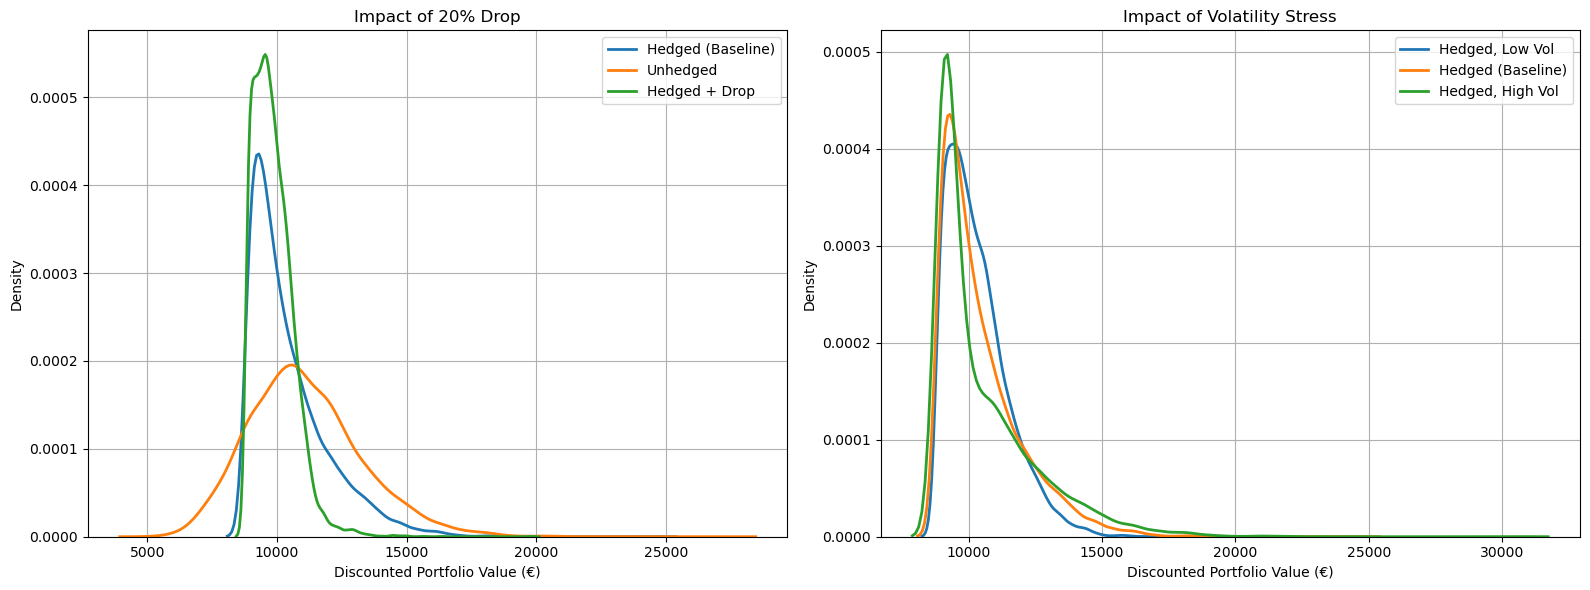

In [7]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- LEFT: Hedged Baseline vs Unhedged vs Drop ---
sns.kdeplot(discounted_values_dict["Baseline Hedged"], label="Hedged (Baseline)", ax=axes[0], linewidth=2)
sns.kdeplot(discounted_values_dict["Unhedged"], label="Unhedged", ax=axes[0], linewidth=2)
sns.kdeplot(discounted_values_dict["Only Drop (−20%)"], label="Hedged + Drop", ax=axes[0], linewidth=2)

axes[0].set_title("Impact of 20% Drop")
axes[0].set_xlabel("Discounted Portfolio Value (€)")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True)

# --- RIGHT: Volatility Stress (No Drop) ---
sns.kdeplot(discounted_values_dict["Only Low Vol (−5pp)"], label="Hedged, Low Vol", ax=axes[1], linewidth=2)
sns.kdeplot(discounted_values_dict["Baseline Hedged"], label="Hedged (Baseline)", ax=axes[1], linewidth=2)
sns.kdeplot(discounted_values_dict["Only High Vol (+5pp)"], label="Hedged, High Vol", ax=axes[1], linewidth=2)

axes[1].set_title("Impact of Volatility Stress")
axes[1].set_xlabel("Discounted Portfolio Value (€)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
#plt.savefig("stress_scenarios_distribution.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

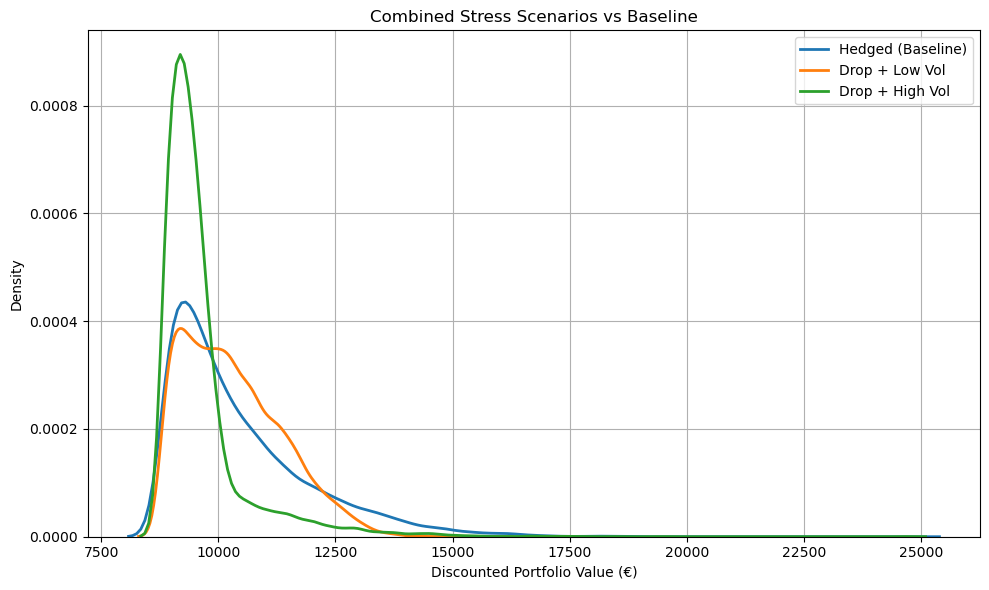

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plot the three relevant scenarios
sns.kdeplot(discounted_values_dict["Baseline Hedged"], label="Hedged (Baseline)", linewidth=2)
sns.kdeplot(discounted_values_dict["Drop + Low Vol"], label="Drop + Low Vol", linewidth=2)
sns.kdeplot(discounted_values_dict["Drop + High Vol"], label="Drop + High Vol", linewidth=2)

# Formatting
plt.title("Combined Stress Scenarios vs Baseline")
plt.xlabel("Discounted Portfolio Value (€)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("combined_stress_vs_baseline.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

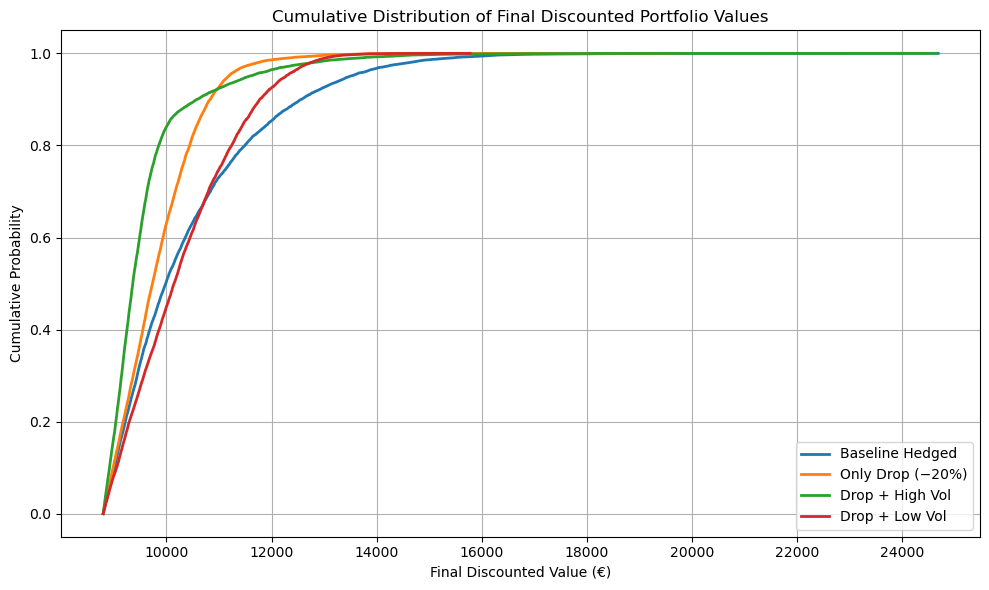

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plot CDFs for four selected cases
plt.figure(figsize=(10, 6))

labels_to_plot = [
    "Baseline Hedged",
    "Only Drop (−20%)",
    "Drop + High Vol",
    "Drop + Low Vol"
]

for label in labels_to_plot:
    data = np.sort(discounted_values_dict[label])
    cdf = np.arange(1, len(data) + 1) / len(data)
    plt.plot(data, cdf, label=label, linewidth=2)

plt.title("Cumulative Distribution of Final Discounted Portfolio Values")
plt.xlabel("Final Discounted Value (€)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("stress_scenarios_cdf.pdf", format="pdf", dpi=300)
plt.show()

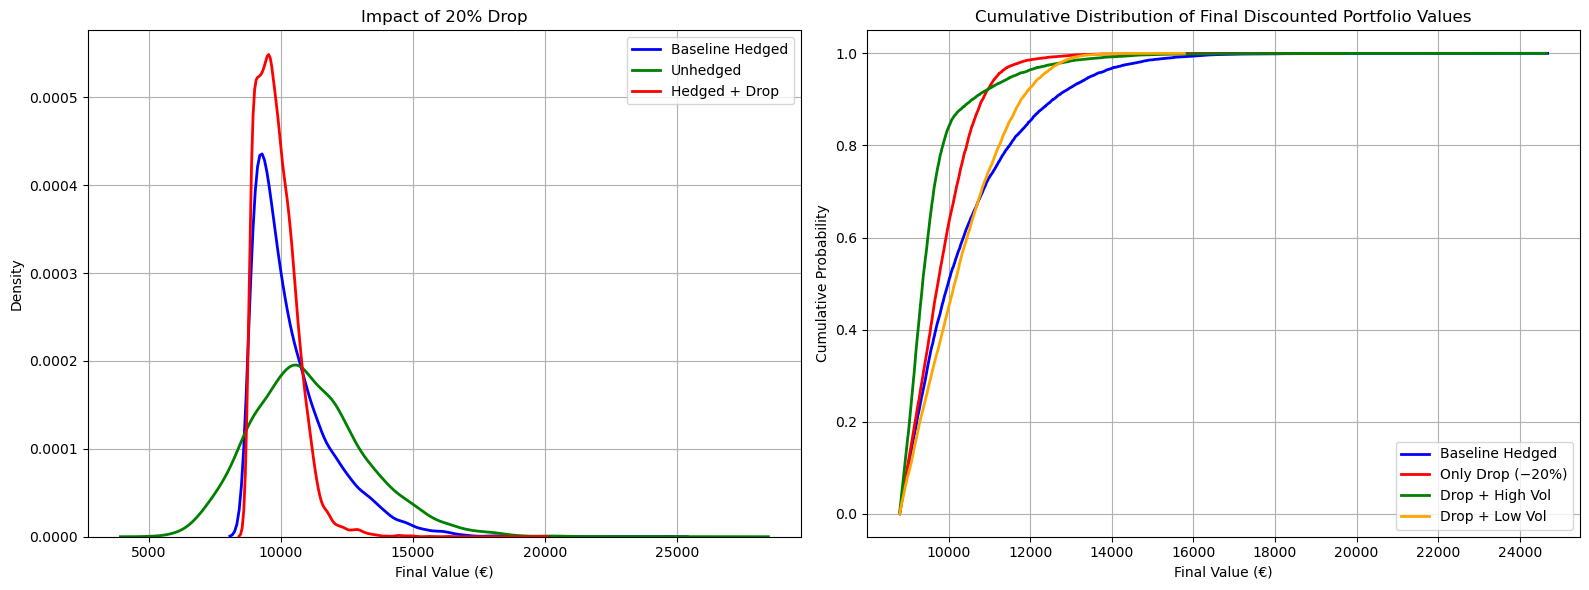

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Define consistent color mapping ---
color_map = {
    "Baseline Hedged": "blue",
    "Unhedged": "green",
    "Only Drop (−20%)": "red",
    "Drop + High Vol": "green",
    "Drop + Low Vol": "orange"
}

# --- Set up 2 subplots side by side ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- LEFT: KDE: Hedged vs Unhedged vs Drop ---
sns.kdeplot(discounted_values_dict["Baseline Hedged"], label="Baseline Hedged", ax=axes[0], linewidth=2, color=color_map["Baseline Hedged"])
sns.kdeplot(discounted_values_dict["Unhedged"], label="Unhedged", ax=axes[0], linewidth=2, color=color_map["Unhedged"])
sns.kdeplot(discounted_values_dict["Only Drop (−20%)"], label="Hedged + Drop", ax=axes[0], linewidth=2, color=color_map["Only Drop (−20%)"])

axes[0].set_title("Impact of 20% Drop")
axes[0].set_xlabel("Final Value (€)")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(True)

# --- RIGHT: CDFs for 4 hedged scenarios ---
labels_to_plot = [
    "Baseline Hedged",
    "Only Drop (−20%)",
    "Drop + High Vol",
    "Drop + Low Vol"
]

for label in labels_to_plot:
    data = np.sort(discounted_values_dict[label])
    cdf = np.arange(1, len(data) + 1) / len(data)
    axes[1].plot(data, cdf, label=label, linewidth=2, color=color_map[label])

axes[1].set_title("Cumulative Distribution of Final Discounted Portfolio Values")
axes[1].set_xlabel("Final Value (€)")
axes[1].set_ylabel("Cumulative Probability")
axes[1].legend()
axes[1].grid(True)

# --- Final Layout ---
plt.tight_layout()
#plt.savefig("stress_analysis_kde_cdf_combined.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()